In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.kernel_approximation import RBFSampler
from sklearn.kernel_ridge import KernelRidge
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
import numpy as np

In [32]:
largeml = pd.read_parquet('data2/largeml.pq')
sample = largeml[largeml['permno'] == 10078]
sample

,permno,yyyymm,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,...,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade12M,zerotrade1M,zerotrade6M,ret
0,10078,198606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.393044e-08,NaN,-0.118056
1,10078,198607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.737205e-08,NaN,-0.039370
2,10078,198609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.597698e-08,1.857281e-07,-0.008850
3,10078,198610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.763825e-08,2.111030e-07,0.348214
4,10078,198612,0.236302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.718727,NaN,5.878542e-09,8.619326e-08,0.109827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,10078,200907,2.075750,1.035556,-0.01837,0.035324,NaN,NaN,NaN,0.004632,...,-0.017203,NaN,NaN,NaN,NaN,0.565433,1.279278e-08,4.992541e-09,2.062345e-08,-0.005423
195,10078,200908,2.051145,1.035556,-0.01837,0.035324,NaN,NaN,NaN,0.004577,...,-0.017203,NaN,NaN,NaN,NaN,0.565433,1.321250e-08,5.435728e-09,2.001079e-08,0.011996
196,10078,200909,2.092252,1.035556,-0.01837,0.035324,NaN,NaN,NaN,0.004669,...,-0.013053,NaN,NaN,NaN,NaN,0.565433,1.352885e-08,6.155693e-09,1.989401e-08,-0.020474
197,10078,200911,2.235027,1.035556,-0.01837,0.035324,NaN,NaN,NaN,0.004988,...,-0.013053,NaN,NaN,NaN,NaN,0.565433,1.352617e-08,4.357210e-09,3.420925e-08,0.040342


In [33]:
exclude = ["permno", "yyyymm", "ret"]
feature_cols = [c for c in largeml.columns if c not in exclude]

missing_rate = largeml[feature_cols].isna().mean().sort_values(ascending=False)
missing_count = largeml[feature_cols].isna().sum().loc[missing_rate.index]

missing_summary = pd.DataFrame({
    "missing_rate": missing_rate,
    "missing_count": missing_count,
    "non_missing_count": len(largeml) - missing_count,
})

missing_summary.head(25)


,missing_rate,missing_count,non_missing_count
RDcap,1.000000,79146,0
ProbInformedTrading,0.999987,79145,1
ChNAnalyst,0.999773,79128,18
IO_ShortInterest,0.997903,78980,166
std_turn,0.996146,78841,305
CitationsRD,0.995009,78751,395
PatentsRD,0.994782,78733,413
Activism2,0.981326,77668,1478
EarnSupBig,0.980264,77584,1562
IndRetBig,0.979708,77540,1606


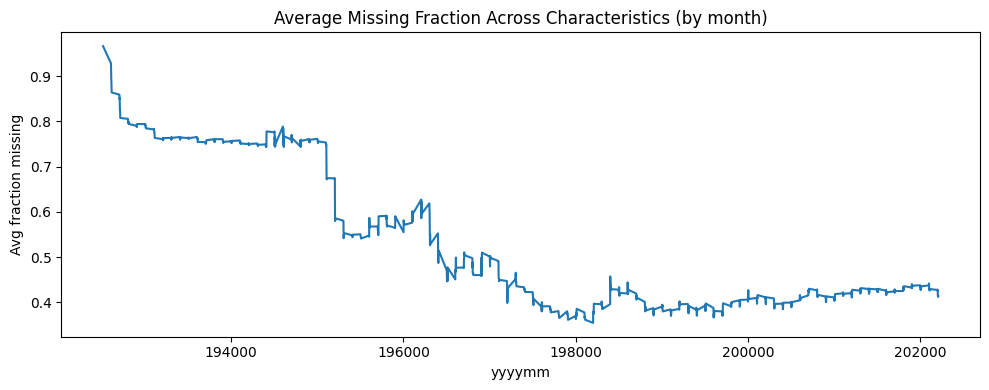

count    849.000000
mean       0.540464
std        0.162007
min        0.354376
25%        0.405825
50%        0.446172
75%        0.750239
max        0.966507
Name: avg_missing_frac, dtype: float64

In [34]:
# Missing fraction across ALL features, averaged across all firm-month rows
missing_by_month = largeml.groupby("yyyymm")[feature_cols].apply(lambda g: g.isna().mean().mean())
missing_by_month.name = "avg_missing_frac"

plt.figure(figsize=(10,4))
missing_by_month.plot()
plt.title("Average Missing Fraction Across Characteristics (by month)")
plt.ylabel("Avg fraction missing")
plt.tight_layout()
plt.show()

missing_by_month.describe()


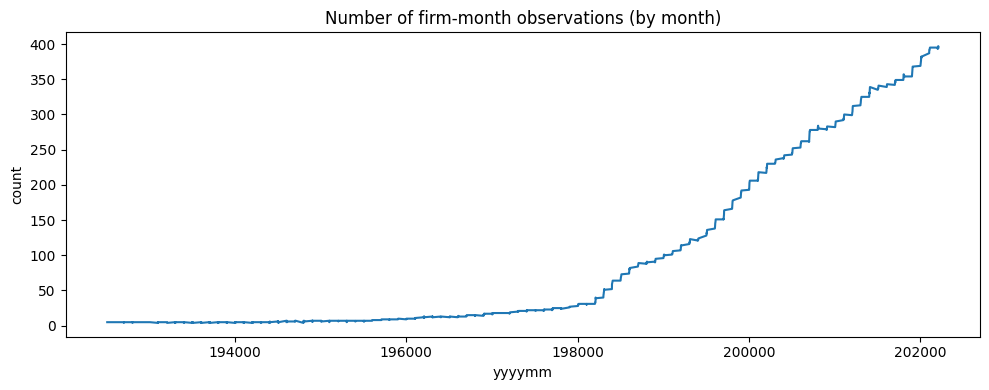

In [35]:
obs_by_month = largeml.groupby("yyyymm").size()
plt.figure(figsize=(10,4))
obs_by_month.plot()
plt.title("Number of firm-month observations (by month)")
plt.ylabel("count")
plt.tight_layout()
plt.show()


In [36]:
cutoffs = [0.50, 0.70, 0.80, 0.90, 0.95, 0.98]
coverage = {c: (missing_rate < c).sum() for c in cutoffs}
pd.Series(coverage, name="#features with missing_rate < cutoff")


0.50    145
0.70    170
0.80    177
0.90    185
0.95    192
0.98    200
Name: #features with missing_rate < cutoff, dtype: int64

In [37]:
largeml['yyyymm'] = pd.to_datetime(largeml['yyyymm'], format='%Y%m')
missing_pct = (largeml.isnull().sum() / len(largeml) * 100).sort_values(ascending=False)
exclude_cols = ["permno", "yyyymm", "ret"]
candidate_cols = [c for c in largeml.columns if c not in exclude_cols]

# coerce any object columns that are really numeric
for c in candidate_cols:
    if largeml[c].dtype == "object":
        largeml[c] = pd.to_numeric(largeml[c], errors="coerce")

characteristic_cols = [c for c in candidate_cols if pd.api.types.is_numeric_dtype(largeml[c])]


Top 10 characteristics by annualized Sharpe:
MS                    7.219656
High52                5.197670
retConglomerate       4.186559
AnnouncementReturn    3.969386
Governance            2.840473
ChForecastAccrual     2.770716
ConsRecomm            2.560654
dVolPut               2.350749
CustomerMomentum      2.118902
NumEarnIncrease       1.789337
dtype: float64

Bottom 10 characteristics by annualized Sharpe:
Frontier        -1.688285
RD              -1.700069
IntanCFP        -1.711865
IntanEP         -1.902003
IndIPO          -2.372818
OptionVolume2   -2.541470
dVolCall        -2.619747
MaxRet          -3.267376
ReturnSkew      -6.278690
ReturnSkew3F    -6.620505
dtype: float64


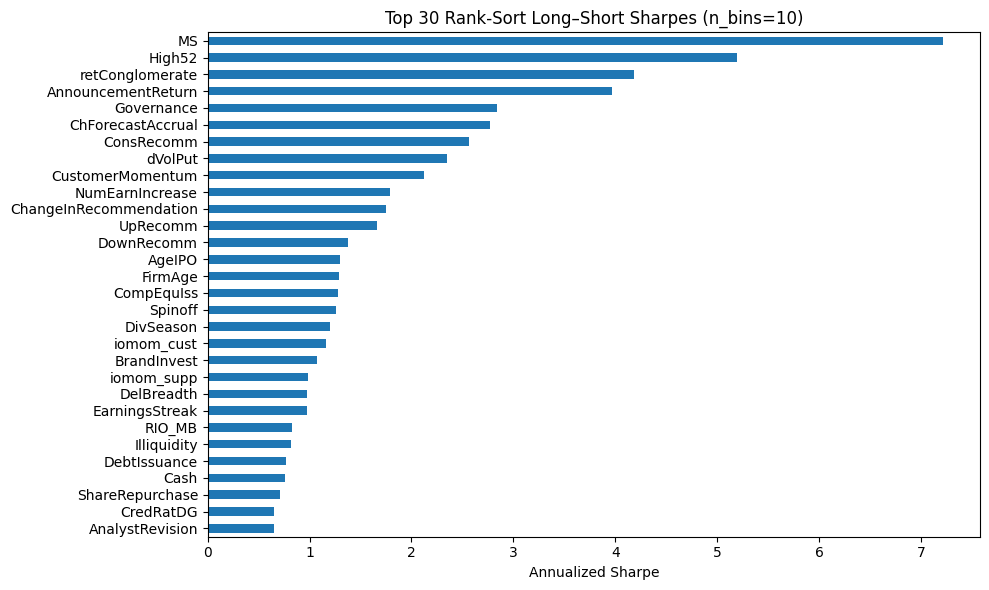


Best characteristic: MS Sharpe: 7.219655778794794
count    3.000000
mean     0.041283
std      0.019808
min      0.019255
25%      0.033109
50%      0.046963
75%      0.052297
max      0.057631
Name: MS, dtype: float64

Worst characteristic: ReturnSkew3F Sharpe: -6.62050515540254
count    356.000000
mean      -0.089070
std        0.046605
min       -0.303061
25%       -0.118940
50%       -0.087293
75%       -0.060322
max        0.017608
Name: ReturnSkew3F, dtype: float64


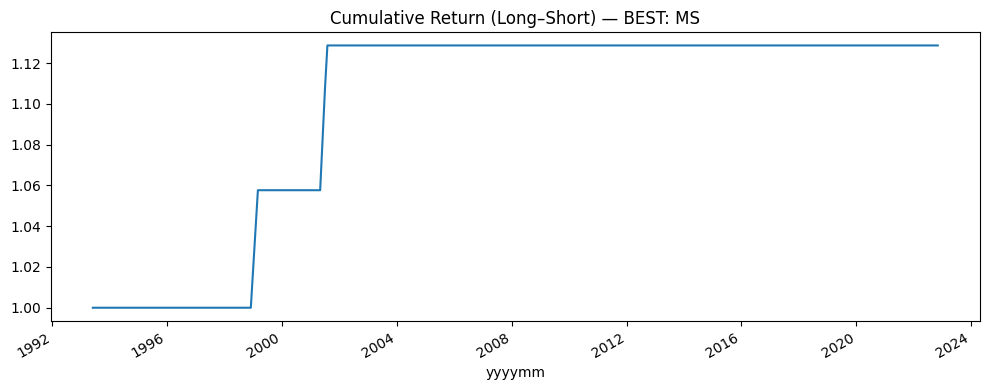

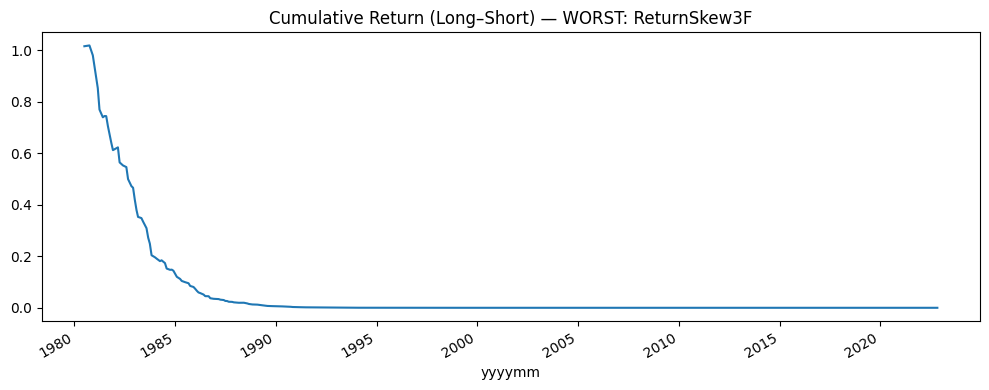

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Load + FIX DTYPES FIRST ---
# If you already loaded largeml earlier, you can still run the coercions below safely.
# largeml = pd.read_parquet("largeml.pq")

# Ensure yyyymm is datetime (adjust format if your yyyymm is already datetime)
largeml["yyyymm"] = pd.to_datetime(largeml["yyyymm"], format="%Y%m", errors="coerce")

# CRITICAL FIX: returns must be numeric (your error was because ret was object/strings)
largeml["ret"] = pd.to_numeric(largeml["ret"], errors="coerce")

# Build characteristic columns (exclude identifiers)
exclude_cols = ["permno", "yyyymm", "ret"]
candidate_cols = [c for c in largeml.columns if c not in exclude_cols]

# Optional but recommended: coerce any object characteristics that are actually numeric
for c in candidate_cols:
    if largeml[c].dtype == "object":
        largeml[c] = pd.to_numeric(largeml[c], errors="coerce")

# Keep only numeric characteristics
characteristic_cols = [c for c in candidate_cols if pd.api.types.is_numeric_dtype(largeml[c])]


def rank_sort_long_short(
    df: pd.DataFrame,
    characteristic: str,
    n_bins: int = 10,          # 10 = deciles, 5 = quintiles
    min_obs_per_month: int = 30
) -> pd.Series:
    """
    For each month:
      1) rank characteristic cross-sectionally
      2) bucket into n_bins (equal-count via qcut)
      3) compute equal-weighted top-bin and bottom-bin returns
      4) return long-short = top - bottom time series
    """
    tmp = df[["yyyymm", "permno", "ret", characteristic]].copy()

    # Make absolutely sure these are numeric even if something slipped through
    tmp["ret"] = pd.to_numeric(tmp["ret"], errors="coerce")
    tmp[characteristic] = pd.to_numeric(tmp[characteristic], errors="coerce")

    tmp = tmp.dropna(subset=["yyyymm", "ret", characteristic])

    if tmp.empty:
        return pd.Series(dtype=float)

    def _bucket_series(s: pd.Series) -> pd.Series:
    # s is the characteristic values for one month, indexed like tmp
        if len(s) < min_obs_per_month:
            return pd.Series(np.nan, index=s.index)
        try:
            b = pd.qcut(s, q=n_bins, labels=False, duplicates="drop")
            return b + 1
        except ValueError:
            return pd.Series(np.nan, index=s.index)

    tmp["bin"] = tmp.groupby("yyyymm", group_keys=False)[characteristic].apply(_bucket_series)
    tmp = tmp.dropna(subset=["bin"])
    tmp["bin"] = tmp["bin"].astype(int)

    if tmp.empty:
        return pd.Series(dtype=float)

    # equal-weighted returns by bin each month
    bin_rets = tmp.groupby(["yyyymm", "bin"])["ret"].mean().unstack()

    # need both bottom and top bins present
    bottom = 1
    top = bin_rets.columns.max()

    # if somehow the bottom/top bin is missing for a month, subtraction yields NaN (fine)
    ls = bin_rets[top] - bin_rets[bottom]
    ls.name = characteristic
    return ls


def annualized_sharpe(r: pd.Series, periods_per_year: int = 12) -> float:
    r = r.dropna()
    if len(r) < 2:
        return np.nan
    mu = r.mean()
    sd = r.std(ddof=1)
    if sd == 0:
        return np.nan
    return (mu / sd) * np.sqrt(periods_per_year)


# --- Compute long-short Sharpe for every characteristic ---
n_bins = 10   # set to 5 if you want quintiles
ls_returns = {}
sharpe = {}

for char in characteristic_cols:
    # skip extremely sparse characteristics
    if largeml[char].isna().mean() > 0.95:
        continue

    r_ls = rank_sort_long_short(largeml, char, n_bins=n_bins)
    if not r_ls.empty:
        ls_returns[char] = r_ls
        sharpe[char] = annualized_sharpe(r_ls)

sharpe_s = pd.Series(sharpe).dropna().sort_values(ascending=False)

print("Top 10 characteristics by annualized Sharpe:")
print(sharpe_s.head(10))

print("\nBottom 10 characteristics by annualized Sharpe:")
print(sharpe_s.tail(10))


# --- Plot results ---
plt.figure(figsize=(10, 6))
sharpe_s.head(30).sort_values().plot(kind="barh")
plt.title(f"Top 30 Rank-Sort Long–Short Sharpes (n_bins={n_bins})")
plt.xlabel("Annualized Sharpe")
plt.tight_layout()
plt.show()


# --- Examine best and worst performers more closely ---
best_char = sharpe_s.index[0]
worst_char = sharpe_s.index[-1]

best_ls = ls_returns[best_char]
worst_ls = ls_returns[worst_char]

print("\nBest characteristic:", best_char, "Sharpe:", sharpe_s.iloc[0])
print(best_ls.describe())

print("\nWorst characteristic:", worst_char, "Sharpe:", sharpe_s.iloc[-1])
print(worst_ls.describe())

# Optional: cumulative performance plots
plt.figure(figsize=(10, 4))
(1 + best_ls.fillna(0)).cumprod().plot()
plt.title(f"Cumulative Return (Long–Short) — BEST: {best_char}")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
(1 + worst_ls.fillna(0)).cumprod().plot()
plt.title(f"Cumulative Return (Long–Short) — WORST: {worst_char}")
plt.tight_layout()
plt.show()


In [39]:
# Question 1 part B

# ============================================================================
# Cell 1: Data Preparation & Train/Test Split
# ============================================================================

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Ensure proper data types
largeml["ret"] = pd.to_numeric(largeml["ret"], errors="coerce")
if not pd.api.types.is_datetime64_any_dtype(largeml["yyyymm"]):
    largeml["yyyymm"] = pd.to_datetime(largeml["yyyymm"], format="%Y%m")

# Train/Test Split (20 years training)
months = pd.DatetimeIndex(np.sort(largeml["yyyymm"].dropna().unique()))
train_end = months[20 * 12 - 1]

train_mask = largeml["yyyymm"] <= train_end
test_mask = largeml["yyyymm"] > train_end

print(f"Train period: {months[0].strftime('%Y-%m')} to {train_end.strftime('%Y-%m')}")
print(f"Test period:  {months[20*12].strftime('%Y-%m')} to {months[-1].strftime('%Y-%m')}")
print(f"Train observations: {train_mask.sum():,}")
print(f"Test observations:  {test_mask.sum():,}")

# Define all potential characteristics
exclude_cols = ["permno", "yyyymm", "ret"]
all_characteristics = [c for c in largeml.columns if c not in exclude_cols]

# Calculate missingness ONLY on training data
train_data = largeml.loc[train_mask]
train_missingness = {col: (train_data[col].isna().sum() / len(train_data)) * 100 
                     for col in all_characteristics}

# Filter based on TRAINING missingness only
MISSINGNESS_THRESHOLD = 95
characteristic_cols = [col for col, pct in train_missingness.items() 
                       if pct <= MISSINGNESS_THRESHOLD]

print(f"\nCharacteristics:")
print(f"  Total available: {len(all_characteristics)}")
print(f"  Dropped (>{MISSINGNESS_THRESHOLD}% missing in training): {len(all_characteristics) - len(characteristic_cols)}")
print(f"  Retained: {len(characteristic_cols)}")

# Prepare train/test sets
X_train = largeml.loc[train_mask, characteristic_cols]
y_train = largeml.loc[train_mask, "ret"]
X_test = largeml.loc[test_mask, characteristic_cols]
y_test = largeml.loc[test_mask, "ret"]

# Remove rows with missing returns
train_valid = y_train.notna()
test_valid = y_test.notna()

X_train_fit = X_train.loc[train_valid]
y_train_fit = y_train.loc[train_valid]
X_test_eval = X_test.loc[test_valid]
y_test_eval = y_test.loc[test_valid]

print(f"\nFinal shapes:")
print(f"  X_train: {X_train_fit.shape}")
print(f"  X_test:  {X_test_eval.shape}")
print(f"  y_train: {y_train_fit.shape}")
print(f"  y_test:  {y_test_eval.shape}")

Train period: 1925-12 to 1950-05
Test period:  1950-06 to 2022-11
Train observations: 1,209
Test observations:  77,937

Characteristics:
  Total available: 209
  Dropped (>95% missing in training): 154
  Retained: 55

Final shapes:
  X_train: (1203, 55)
  X_test:  (77594, 55)
  y_train: (1203,)
  y_test:  (77594,)


In [40]:
# ============================================================================
# Part (b)i: OLS over Linear Characteristics
# ============================================================================

# Build OLS pipeline
ols = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

# Train
print("Training OLS model...")
ols.fit(X_train_fit, y_train_fit)
print("✓ Training complete")

# Predict
y_pred_ols = ols.predict(X_test_eval)

# Evaluate
r2_ols = r2_score(y_test_eval, y_pred_ols)

# Results
print("\n" + "="*60)
print("OLS OUT-OF-SAMPLE R²")
print("="*60)
print(f"\nR² = {r2_ols:.6f}")
print(f"\nInterpretation:")
print(f"  The OLS model explains {r2_ols*100:.2f}% of the variance")
print(f"  in stock returns out-of-sample.")
print("="*60)

Training OLS model...
✓ Training complete

OLS OUT-OF-SAMPLE R²

R² = -314.645124

Interpretation:
  The OLS model explains -31464.51% of the variance
  in stock returns out-of-sample.


In [41]:
# ============================================================================
# Part (b)ii: Ridge Regression over Linear Characteristics
# ============================================================================

from sklearn.linear_model import RidgeCV

# Build Ridge pipeline with cross-validation for alpha
ridge = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", RidgeCV(alphas=[0.01, 0.1, 1, 10, 100, 1000]))
])

# Train
print("Training Ridge model...")
ridge.fit(X_train_fit, y_train_fit)
print(f"✓ Best alpha: {ridge.named_steps['model'].alpha_:.4f}")

# Predict and evaluate
y_pred_ridge = ridge.predict(X_test_eval)
r2_ridge = r2_score(y_test_eval, y_pred_ridge)

print("\n" + "="*60)
print("RIDGE OUT-OF-SAMPLE R²")
print("="*60)
print(f"R² = {r2_ridge:.6f}")
print("="*60)

Training Ridge model...
✓ Best alpha: 10.0000

RIDGE OUT-OF-SAMPLE R²
R² = -262.770868


In [42]:
# ============================================================================
# Part (b)iii: Lasso Regression
# ============================================================================

from sklearn.linear_model import LassoCV

# Build Lasso pipeline
lasso = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LassoCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1], max_iter=10000))
])

# Train
print("Training Lasso model...")
lasso.fit(X_train_fit, y_train_fit)
print(f"✓ Training complete (best alpha: {lasso.named_steps['model'].alpha_})")

# Predict
y_pred_lasso = lasso.predict(X_test_eval)

# Evaluate
r2_lasso = r2_score(y_test_eval, y_pred_lasso)

# Results
print("\n" + "="*60)
print("LASSO OUT-OF-SAMPLE R²")
print("="*60)
print(f"\nR² = {r2_lasso:.6f}")
print(f"Improvement over OLS: {(r2_lasso - r2_ols):.6f}")
print("="*60)

Training Lasso model...
✓ Training complete (best alpha: 0.001)

LASSO OUT-OF-SAMPLE R²

R² = -108.235495
Improvement over OLS: 206.409629


In [43]:
# ============================================================================
# Part (b)ii: Elastic Net over Linear Characteristics
# ============================================================================

from sklearn.linear_model import ElasticNetCV

# Build Elastic Net pipeline
elastic = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", ElasticNetCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1], 
                           l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
                           max_iter=10000, cv=5))
])

# Train
print("Training Elastic Net model...")
elastic.fit(X_train_fit, y_train_fit)
print(f"✓ Best alpha: {elastic.named_steps['model'].alpha_:.6f}")
print(f"✓ Best l1_ratio: {elastic.named_steps['model'].l1_ratio_:.4f}")

# Predict and evaluate
y_pred_elastic = elastic.predict(X_test_eval)
r2_elastic = r2_score(y_test_eval, y_pred_elastic)

print("\n" + "="*60)
print("ELASTIC NET OUT-OF-SAMPLE R²")
print("="*60)
print(f"R² = {r2_elastic:.6f}")
print("="*60)

Training Elastic Net model...
✓ Best alpha: 0.010000
✓ Best l1_ratio: 0.1000

ELASTIC NET OUT-OF-SAMPLE R²
R² = -92.019892


In [44]:
# ============================================================================
# Part (b)iii: Ridge over Non-linear Expansion (RBF)
# ============================================================================

from sklearn.kernel_approximation import RBFSampler

# Build Ridge with RBF pipeline
ridge_rbf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("rbf", RBFSampler(n_components=100, gamma=1.0, random_state=42)),
    ("model", RidgeCV(alphas=[0.01, 0.1, 1, 10, 100, 1000]))
])

# Train
print("Training Ridge with RBF expansion...")
ridge_rbf.fit(X_train_fit, y_train_fit)
print(f"✓ Best alpha: {ridge_rbf.named_steps['model'].alpha_:.4f}")

# Predict and evaluate
y_pred_ridge_rbf = ridge_rbf.predict(X_test_eval)
r2_ridge_rbf = r2_score(y_test_eval, y_pred_ridge_rbf)

print("\n" + "="*60)
print("RIDGE + RBF OUT-OF-SAMPLE R²")
print("="*60)
print(f"R² = {r2_ridge_rbf:.6f}")
print("="*60)

Training Ridge with RBF expansion...
✓ Best alpha: 100.0000

RIDGE + RBF OUT-OF-SAMPLE R²
R² = -0.003503


In [45]:
# ============================================================================
# Part (b)iii: Lasso over Non-linear Expansion (RBF)
# ============================================================================

# Lasso + RBF - try different gamma
lasso_rbf_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('rbf', RBFSampler(n_components=50, gamma=1.0, random_state=42)),  # Changed from 0.1 to 1.0
    ('lasso', LassoCV(
        alphas=np.logspace(-6, -1, 30),
        cv=TimeSeriesSplit(n_splits=5),
        max_iter=10000,
        random_state=42
    ))
])

# Train
print("Training Lasso with RBF expansion...")
lasso_rbf_pipeline.fit(X_train_fit, y_train_fit)
print(f"✓ Best alpha: {lasso_rbf_pipeline.named_steps['lasso'].alpha_:.6f}")

# Predict and evaluate
y_pred_lasso_rbf = lasso_rbf_pipeline.predict(X_test_eval)
r2_lasso_rbf = r2_score(y_test_eval, y_pred_lasso_rbf)

print("\n" + "="*60)
print("LASSO + RBF OUT-OF-SAMPLE R²")
print("="*60)
print(f"R² = {r2_lasso_rbf:.6f}")
print("="*60)

Training Lasso with RBF expansion...
✓ Best alpha: 0.000574

LASSO + RBF OUT-OF-SAMPLE R²
R² = -0.007043


In [46]:
# ============================================================================
# Part (b)iii: Elastic Net over Non-linear Expansion (RBF)
# ============================================================================

# Build Elastic Net with RBF pipeline
elastic_rbf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("rbf", RBFSampler(n_components=100, gamma=1.0, random_state=42)),
    ("model", ElasticNetCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1], 
                           l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95],
                           max_iter=10000, cv=5))
])

# Train
print("Training Elastic Net with RBF expansion...")
elastic_rbf.fit(X_train_fit, y_train_fit)
print(f"✓ Best alpha: {elastic_rbf.named_steps['model'].alpha_:.6f}")
print(f"✓ Best l1_ratio: {elastic_rbf.named_steps['model'].l1_ratio_:.4f}")

# Predict and evaluate
y_pred_elastic_rbf = elastic_rbf.predict(X_test_eval)
r2_elastic_rbf = r2_score(y_test_eval, y_pred_elastic_rbf)

print("\n" + "="*60)
print("ELASTIC NET + RBF OUT-OF-SAMPLE R²")
print("="*60)
print(f"R² = {r2_elastic_rbf:.6f}")
print("="*60)

Training Elastic Net with RBF expansion...
✓ Best alpha: 1.000000
✓ Best l1_ratio: 0.1000

ELASTIC NET + RBF OUT-OF-SAMPLE R²
R² = -0.003027


In [47]:
# ============================================================================
# Part (b)iv: PLS Regression over Linear Characteristics
# ============================================================================

from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score

# Find best number of components using cross-validation on training data
print("Finding optimal number of PLS components...")
n_components_range = range(1, min(50, len(characteristic_cols)) + 1, 5)
cv_scores = []

for n_comp in n_components_range:
    pls_temp = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", PLSRegression(n_components=n_comp))
    ])
    # Use a subset for speed
    scores = cross_val_score(pls_temp, X_train_fit.iloc[:10000], y_train_fit.iloc[:10000], 
                            cv=5, scoring='r2')
    cv_scores.append(scores.mean())

best_n_components = list(n_components_range)[np.argmax(cv_scores)]
print(f"✓ Best number of components: {best_n_components}")

# Build PLS pipeline with best components
pls = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", PLSRegression(n_components=best_n_components))
])

# Train
print("Training PLS model...")
pls.fit(X_train_fit, y_train_fit)

# Predict and evaluate
y_pred_pls = pls.predict(X_test_eval)
r2_pls = r2_score(y_test_eval, y_pred_pls)

print("\n" + "="*60)
print("PLS REGRESSION OUT-OF-SAMPLE R²")
print("="*60)
print(f"R² = {r2_pls:.6f}")
print("="*60)

Finding optimal number of PLS components...
✓ Best number of components: 1
Training PLS model...

PLS REGRESSION OUT-OF-SAMPLE R²
R² = -181.054039


In [48]:
# ============================================================================
# Part (b)iv: PLS Regression over Non-linear Expansion (RBF)
# ============================================================================

# Build PLS with RBF pipeline
pls_rbf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("rbf", RBFSampler(n_components=100, gamma=0.1, random_state=42)),
    ("model", PLSRegression(n_components=min(20, 100)))  # Can't exceed RBF components
])

# Train
print("Training PLS with RBF expansion...")
pls_rbf.fit(X_train_fit, y_train_fit)

# Predict and evaluate
y_pred_pls_rbf = pls_rbf.predict(X_test_eval)
r2_pls_rbf = r2_score(y_test_eval, y_pred_pls_rbf)

print("\n" + "="*60)
print("PLS + RBF OUT-OF-SAMPLE R²")
print("="*60)
print(f"R² = {r2_pls_rbf:.6f}")
print("="*60)

Training PLS with RBF expansion...

PLS + RBF OUT-OF-SAMPLE R²
R² = -0.067419


In [49]:
# ============================================================================
# Part (b)v: Gradient Boosting Regressor
# ============================================================================

from sklearn.ensemble import GradientBoostingRegressor

# Build Gradient Boosting pipeline
gb = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        subsample=0.8,
        random_state=42,
        verbose=0
    ))
])

# Train
print("Training Gradient Boosting model...")
print("(This may take a few minutes...)")
gb.fit(X_train_fit, y_train_fit)
print("✓ Training complete")

# Predict and evaluate
y_pred_gb = gb.predict(X_test_eval)
r2_gb = r2_score(y_test_eval, y_pred_gb)

print("\n" + "="*60)
print("GRADIENT BOOSTING OUT-OF-SAMPLE R²")
print("="*60)
print(f"R² = {r2_gb:.6f}")
print("="*60)

Training Gradient Boosting model...
(This may take a few minutes...)
✓ Training complete

GRADIENT BOOSTING OUT-OF-SAMPLE R²
R² = -1.426618


In [50]:
# ============================================================================
# Part (c): Form Portfolios from ML Predictions
# ============================================================================

def form_long_short_portfolio(predictions, actual_returns, n_quantiles=10):
    """
    Form long-short portfolio based on predicted returns.
    
    For each month:
    - Sort stocks by predicted returns
    - Long top decile, short bottom decile
    - Equal-weighted within each leg
    
    Returns: DataFrame with monthly long-short returns
    """
    # Create dataframe with predictions and actual returns
    # predictions and actual_returns are already aligned (both from test set)
    portfolio_df = pd.DataFrame({
        'yyyymm': largeml.loc[test_mask, 'yyyymm'].values,
        'predicted': np.nan,
        'actual': largeml.loc[test_mask, 'ret'].values
    })
    
    # Fill in predictions (only where actual returns are not NaN)
    portfolio_df.loc[test_valid.values, 'predicted'] = predictions
    
    # Remove rows with NaN actual returns or predictions
    portfolio_df = portfolio_df.dropna(subset=['actual', 'predicted'])
    
    monthly_returns = []
    
    for month in portfolio_df['yyyymm'].unique():
        month_data = portfolio_df[portfolio_df['yyyymm'] == month].copy()
        
        # Need enough stocks to form deciles
        if len(month_data) < n_quantiles * 2:
            continue
        
        # Rank by predicted returns and create deciles
        month_data['decile'] = pd.qcut(
            month_data['predicted'],
            q=n_quantiles,
            labels=False,
            duplicates='drop'
        )
        # Convert to 1-based labels (qcut with labels=False gives 0-based)
        month_data['decile'] = month_data['decile'] + 1
        
        # Long top decile, short bottom decile
        # Use actual max/min decile values (might be less than n_quantiles if duplicates dropped)
        top_decile = month_data['decile'].max()
        bottom_decile = month_data['decile'].min()
        
        long_ret = month_data[month_data['decile'] == top_decile]['actual'].mean()
        short_ret = month_data[month_data['decile'] == bottom_decile]['actual'].mean()
        
        monthly_returns.append({
            'yyyymm': month,
            'long_short': long_ret - short_ret,
            'long': long_ret,
            'short': short_ret
        })
    
    return pd.DataFrame(monthly_returns)


def calculate_sharpe_ratio(returns, periods_per_year=12):
    """Calculate annualized Sharpe ratio."""
    returns = returns.dropna()
    if len(returns) < 2:
        return np.nan
    mean_ret = returns.mean()
    std_ret = returns.std()
    if std_ret == 0:
        return np.nan
    return (mean_ret / std_ret) * np.sqrt(periods_per_year)


# Form portfolios for all models
print("="*80)
print("FORMING PORTFOLIOS FROM ML PREDICTIONS")
print("="*80)

portfolios = {}

# OLS
print("\nForming OLS portfolio...")
portfolios['OLS'] = form_long_short_portfolio(y_pred_ols, y_test_eval)

# Ridge
print("Forming Ridge portfolio...")
portfolios['Ridge'] = form_long_short_portfolio(y_pred_ridge, y_test_eval)

# Lasso
print("Forming Lasso portfolio...")
portfolios['Lasso'] = form_long_short_portfolio(y_pred_lasso, y_test_eval)

# Elastic Net
print("Forming Elastic Net portfolio...")
portfolios['Elastic Net'] = form_long_short_portfolio(y_pred_elastic, y_test_eval)

# Ridge + RBF
print("Forming Ridge+RBF portfolio...")
portfolios['Ridge+RBF'] = form_long_short_portfolio(y_pred_ridge_rbf, y_test_eval)

# Lasso + RBF
print("Forming Lasso+RBF portfolio...")
portfolios['Lasso+RBF'] = form_long_short_portfolio(y_pred_lasso_rbf, y_test_eval)

# Elastic Net + RBF
print("Forming Elastic+RBF portfolio...")
portfolios['Elastic+RBF'] = form_long_short_portfolio(y_pred_elastic_rbf, y_test_eval)

# PLS
print("Forming PLS portfolio...")
portfolios['PLS'] = form_long_short_portfolio(y_pred_pls, y_test_eval)

# PLS + RBF
print("Forming PLS+RBF portfolio...")
portfolios['PLS+RBF'] = form_long_short_portfolio(y_pred_pls_rbf, y_test_eval)

# Gradient Boosting
print("Forming Gradient Boosting portfolio...")
portfolios['Gradient Boosting'] = form_long_short_portfolio(y_pred_gb, y_test_eval)

print("\n✓ All portfolios formed")

FORMING PORTFOLIOS FROM ML PREDICTIONS

Forming OLS portfolio...
Forming Ridge portfolio...
Forming Lasso portfolio...
Forming Elastic Net portfolio...
Forming Ridge+RBF portfolio...
Forming Lasso+RBF portfolio...
Forming Elastic+RBF portfolio...
Forming PLS portfolio...
Forming PLS+RBF portfolio...
Forming Gradient Boosting portfolio...

✓ All portfolios formed


In [51]:
# Diagnostic code to check Lasso+RBF predictions
print("\n" + "="*80)
print("DIAGNOSTIC: Checking Lasso+RBF predictions")
print("="*80)

print(f"\nNumber of predictions: {len(y_pred_lasso_rbf)}")
print(f"Number of NaN predictions: {np.isnan(y_pred_lasso_rbf).sum()}")
print(f"Number of unique predictions: {len(np.unique(y_pred_lasso_rbf[~np.isnan(y_pred_lasso_rbf)]))}")
print(f"\nPrediction statistics:")
print(f"  Min: {np.nanmin(y_pred_lasso_rbf)}")
print(f"  Max: {np.nanmax(y_pred_lasso_rbf)}")
print(f"  Mean: {np.nanmean(y_pred_lasso_rbf)}")
print(f"  Std: {np.nanstd(y_pred_lasso_rbf)}")




DIAGNOSTIC: Checking Lasso+RBF predictions

Number of predictions: 77594
Number of NaN predictions: 0
Number of unique predictions: 77594

Prediction statistics:
  Min: -0.00371655241421163
  Max: 0.02202307082521296
  Mean: 0.009181237488752146
  Std: 0.006036910749349352


In [52]:
# ============================================================================
# Display Portfolio Performance and Sharpe Ratios
# ============================================================================

print("\n" + "="*80)
print("PORTFOLIO PERFORMANCE SUMMARY")
print("="*80)

# Create summary table
summary_results = []

for model_name, portfolio in portfolios.items():
    if len(portfolio) > 0:
        long_short_returns = portfolio['long_short']
        
        # Calculate statistics
        mean_return = long_short_returns.mean()
        std_return = long_short_returns.std()
        sharpe = calculate_sharpe_ratio(long_short_returns)
        
        # Annualized metrics
        ann_return = mean_return * 12
        ann_std = std_return * np.sqrt(12)
        
        summary_results.append({
            'Model': model_name,
            'Mean Monthly Return': mean_return,
            'Annualized Return': ann_return,
            'Monthly Std Dev': std_return,
            'Annualized Std Dev': ann_std,
            'Sharpe Ratio': sharpe,
            'N Months': len(long_short_returns)
        })

# Create DataFrame and display
summary_df = pd.DataFrame(summary_results)
summary_df = summary_df.sort_values('Sharpe Ratio', ascending=False)

print("\n")
print(summary_df.to_string(index=False))

# Display top 3 models
print("\n" + "="*80)
print("TOP 3 MODELS BY SHARPE RATIO")
print("="*80)
for i, row in summary_df.head(3).iterrows():
    print(f"\n{row['Model']}:")
    print(f"  Sharpe Ratio: {row['Sharpe Ratio']:.4f}")
    print(f"  Annualized Return: {row['Annualized Return']*100:.2f}%")
    print(f"  Annualized Std Dev: {row['Annualized Std Dev']*100:.2f}%")



# Optional: Plot individual model details
print("\n" + "="*80)
print("DETAILED STATISTICS BY MODEL")
print("="*80)

for model_name, portfolio in portfolios.items():
    if len(portfolio) > 0:
        print(f"\n{model_name}:")
        print(f"  Mean Long Return: {portfolio['long'].mean()*100:.3f}%")
        print(f"  Mean Short Return: {portfolio['short'].mean()*100:.3f}%")
        print(f"  Mean Long-Short: {portfolio['long_short'].mean()*100:.3f}%")
        print(f"  Std Long-Short: {portfolio['long_short'].std()*100:.3f}%")


PORTFOLIO PERFORMANCE SUMMARY


            Model  Mean Monthly Return  Annualized Return  Monthly Std Dev  Annualized Std Dev  Sharpe Ratio  N Months
Gradient Boosting             0.107275           1.287294         0.072949            0.252702      5.094112       422
      Elastic Net             0.084758           1.017101         0.080446            0.278674      3.649789       422
            Lasso             0.084899           1.018792         0.080617            0.279265      3.648119       422
              OLS             0.069452           0.833423         0.077017            0.266796      3.123822       422
            Ridge             0.069402           0.832822         0.077691            0.269130      3.094503       422
              PLS             0.055800           0.669601         0.067026            0.232186      2.883896       422
          PLS+RBF             0.000035           0.000423         0.042397            0.146866      0.002882       422
        Ridge+R

In [53]:
smallml = pd.read_parquet('data2/smallml.pq')

In [54]:
# ============================================================================
# SMALLML Dataset - Initial Exploration
# ============================================================================

print("="*80)
print("SMALLML DATASET - INITIAL EXPLORATION")
print("="*80)
print(f"Shape: {smallml.shape}")
print(f"Date range: {smallml['yyyymm'].min()} to {smallml['yyyymm'].max()}")
print(f"Number of unique stocks: {smallml['permno'].nunique()}")

SMALLML DATASET - INITIAL EXPLORATION
Shape: (21302, 212)
Date range: 192512 to 202211
Number of unique stocks: 977


In [55]:
# ============================================================================
# Define Train/Validation/Test Split - SMALLML
# ============================================================================

print("\n" + "="*80)
print("DEFINING TRAIN/VALIDATION/TEST SPLIT - SMALLML")
print("="*80)

# Calculate split dates
unique_dates = sorted(smallml['yyyymm'].unique())

# First 20 years for training (240 months)
train_months = unique_dates[:240]
# Next 12 years for validation (144 months)
validation_months = unique_dates[240:384]
# Remainder for test
test_months = unique_dates[384:]

train_end = train_months[-1]
validation_end = validation_months[-1]

print(f"\nSplit configuration:")
print(f"Training period: {train_months[0]} to {train_end} ({len(train_months)} months)")
print(f"Validation period: {validation_months[0]} to {validation_end} ({len(validation_months)} months)")
print(f"Test period: {test_months[0]} to {test_months[-1]} ({len(test_months)} months)")

# Create train/validation/test masks
train_mask_small = smallml['yyyymm'] <= train_end
validation_mask_small = (smallml['yyyymm'] > train_end) & (smallml['yyyymm'] <= validation_end)
test_mask_small = smallml['yyyymm'] > validation_end

print(f"\nObservations:")
print(f"Training: {train_mask_small.sum()}")
print(f"Validation: {validation_mask_small.sum()}")
print(f"Test: {test_mask_small.sum()}")


DEFINING TRAIN/VALIDATION/TEST SPLIT - SMALLML

Split configuration:
Training period: 192512 to 195005 (240 months)
Validation period: 195006 to 196705 (144 months)
Test period: 196706 to 202211 (465 months)

Observations:
Training: 7640
Validation: 3308
Test: 10354


In [56]:
# ============================================================================
# Data Cleaning - Drop Columns Based on Training Data - SMALLML
# ============================================================================

print("\n" + "="*80)
print("DATA CLEANING - SMALLML")
print("="*80)

# Check missing values in TRAINING data only
train_data_small = smallml[train_mask_small]

print("\nMissing values in training data:")
missing_pct_train_small = (train_data_small.isna().sum() / len(train_data_small)) * 100
print(missing_pct_train_small[missing_pct_train_small > 0].sort_values(ascending=False).head(20))

# Drop columns with >50% missing in training data
missing_threshold = 50
exclude_cols = ['permno', 'yyyymm', 'ret']
cols_to_check = [col for col in smallml.columns if col not in exclude_cols]

cols_to_drop_small = []
for col in cols_to_check:
    if missing_pct_train_small[col] > missing_threshold:
        cols_to_drop_small.append(col)

print(f"\nDropping {len(cols_to_drop_small)} columns with >{missing_threshold}% missing in training data:")
print(cols_to_drop_small)

# Drop from entire dataset
smallml = smallml.drop(columns=cols_to_drop_small)
print(f"\nShape after dropping columns: {smallml.shape}")

# Update feature list
feature_cols_small = [col for col in smallml.columns if col not in exclude_cols]
print(f"Number of features remaining: {len(feature_cols_small)}")


DATA CLEANING - SMALLML

Missing values in training data:
AM                   100.0
Leverage             100.0
IntanCFP             100.0
IntanEP              100.0
IntanSP              100.0
InvGrowth            100.0
InvestPPEInv         100.0
Investment           100.0
AOP                  100.0
cfp                  100.0
Tax                  100.0
MS                   100.0
betaVIX              100.0
MeanRankRevGrowth    100.0
XFIN                 100.0
VarCF                100.0
UpRecomm             100.0
Mom6mJunk            100.0
IntanBM              100.0
dCPVolSpread         100.0
dtype: float64

Dropping 162 columns with >50% missing in training data:
['AM', 'AOP', 'AbnormalAccruals', 'Accruals', 'AccrualsBM', 'Activism1', 'Activism2', 'AdExp', 'AgeIPO', 'AnalystRevision', 'AnalystValue', 'AnnouncementReturn', 'AssetGrowth', 'BM', 'BMdec', 'BPEBM', 'BetaLiquidityPS', 'BookLeverage', 'BrandInvest', 'CBOperProf', 'CF', 'CPVolSpread', 'Cash', 'CashProd', 'ChAssetTurnover', 'Ch

In [57]:
# ============================================================================
# Part (a): Rank-Sort Each Characteristic and Form Portfolios - SMALLML
# ============================================================================

print("="*80)
print("PART (a): CHARACTERISTIC PORTFOLIOS - SMALLML")
print("="*80)

# Build characteristic columns (exclude identifiers)
exclude_cols = ["permno", "yyyymm", "ret"]
candidate_cols = [c for c in smallml.columns if c not in exclude_cols]

# Optional but recommended: coerce any object characteristics that are actually numeric
for c in candidate_cols:
    if smallml[c].dtype == "object":
        smallml[c] = pd.to_numeric(smallml[c], errors="coerce")

# Keep only numeric characteristics
characteristic_cols = [c for c in candidate_cols if pd.api.types.is_numeric_dtype(smallml[c])]

print(f"\nNumber of characteristics: {len(characteristic_cols)}")


def rank_sort_long_short(
    df: pd.DataFrame,
    characteristic: str,
    n_bins: int = 10,          # 10 = deciles, 5 = quintiles
    min_obs_per_month: int = 30
) -> pd.Series:
    """
    For each month:
      1) rank characteristic cross-sectionally
      2) bucket into n_bins (equal-count via qcut)
      3) compute equal-weighted top-bin and bottom-bin returns
      4) return long-short = top - bottom time series
    """
    tmp = df[["yyyymm", "permno", "ret", characteristic]].copy()

    # Make absolutely sure these are numeric even if something slipped through
    tmp["ret"] = pd.to_numeric(tmp["ret"], errors="coerce")
    tmp[characteristic] = pd.to_numeric(tmp[characteristic], errors="coerce")

    tmp = tmp.dropna(subset=["yyyymm", "ret", characteristic])

    if tmp.empty:
        return pd.Series(dtype=float)

    def _bucket_series(s: pd.Series) -> pd.Series:
        # s is the characteristic values for one month, indexed like tmp
        if len(s) < min_obs_per_month:
            return pd.Series(np.nan, index=s.index)
        try:
            b = pd.qcut(s, q=n_bins, labels=False, duplicates="drop")
            return b + 1
        except ValueError:
            return pd.Series(np.nan, index=s.index)

    tmp["bin"] = tmp.groupby("yyyymm", group_keys=False)[characteristic].apply(_bucket_series)
    tmp = tmp.dropna(subset=["bin"])
    tmp["bin"] = tmp["bin"].astype(int)

    if tmp.empty:
        return pd.Series(dtype=float)

    # equal-weighted returns by bin each month
    bin_rets = tmp.groupby(["yyyymm", "bin"])["ret"].mean().unstack()

    # need both bottom and top bins present
    bottom = 1
    top = bin_rets.columns.max()

    # if somehow the bottom/top bin is missing for a month, subtraction yields NaN (fine)
    ls = bin_rets[top] - bin_rets[bottom]
    ls.name = characteristic
    return ls


def annualized_sharpe(r: pd.Series, periods_per_year: int = 12) -> float:
    r = r.dropna()
    if len(r) < 2:
        return np.nan
    mu = r.mean()
    sd = r.std(ddof=1)
    if sd == 0:
        return np.nan
    return (mu / sd) * np.sqrt(periods_per_year)


# --- Compute long-short Sharpe for every characteristic ---
n_bins = 10   # set to 5 if you want quintiles
ls_returns_small = {}
sharpe_small = {}

for char in characteristic_cols:
    # skip extremely sparse characteristics
    if smallml[char].isna().mean() > 0.95:
        continue

    r_ls = rank_sort_long_short(smallml, char, n_bins=n_bins)
    if not r_ls.empty:
        ls_returns_small[char] = r_ls
        sharpe_small[char] = annualized_sharpe(r_ls)

sharpe_s_small = pd.Series(sharpe_small).dropna().sort_values(ascending=False)

print("\nTop 10 characteristics by annualized Sharpe:")
print(sharpe_s_small.head(10))

print("\nBottom 10 characteristics by annualized Sharpe:")
print(sharpe_s_small.tail(10))

PART (a): CHARACTERISTIC PORTFOLIOS - SMALLML

Number of characteristics: 47

Top 10 characteristics by annualized Sharpe:
High52               2.329760
VolMkt               1.808109
ShareIss5Y           1.197914
IndRetBig            1.074466
zerotrade6M          1.065121
zerotrade1M          0.998946
MomSeason06YrPlus    0.997804
DolVol               0.779883
zerotrade12M         0.735183
Illiquidity          0.720682
dtype: float64

Bottom 10 characteristics by annualized Sharpe:
ResidualMomentum   -0.745019
Mom6m              -0.824383
IdioVol3F          -0.887657
RealizedVol        -0.926238
FirmAge            -0.937968
ShareVol           -1.064707
BetaTailRisk       -1.336214
MaxRet             -1.497075
ReturnSkew3F       -2.194020
ReturnSkew         -2.888088
dtype: float64


In [58]:
# ============================================================================
# Part (b): Data Preparation & Train/Test Split - SMALLML
# ============================================================================

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Ensure proper data types
smallml["ret"] = pd.to_numeric(smallml["ret"], errors="coerce")
if not pd.api.types.is_datetime64_any_dtype(smallml["yyyymm"]):
    smallml["yyyymm"] = pd.to_datetime(smallml["yyyymm"], format="%Y%m")

# Train/Test Split (20 years training)
months = pd.DatetimeIndex(np.sort(smallml["yyyymm"].dropna().unique()))
train_end = months[20 * 12 - 1]

train_mask = smallml["yyyymm"] <= train_end
test_mask = smallml["yyyymm"] > train_end

print(f"Train period: {months[0].strftime('%Y-%m')} to {train_end.strftime('%Y-%m')}")
print(f"Test period:  {months[20*12].strftime('%Y-%m')} to {months[-1].strftime('%Y-%m')}")
print(f"Train observations: {train_mask.sum():,}")
print(f"Test observations:  {test_mask.sum():,}")

# Define all potential characteristics
exclude_cols = ["permno", "yyyymm", "ret"]
all_characteristics = [c for c in smallml.columns if c not in exclude_cols]

# Calculate missingness ONLY on training data
train_data = smallml.loc[train_mask]
train_missingness = {col: (train_data[col].isna().sum() / len(train_data)) * 100 
                     for col in all_characteristics}

# Filter based on TRAINING missingness only
MISSINGNESS_THRESHOLD = 95
characteristic_cols = [col for col, pct in train_missingness.items() 
                       if pct <= MISSINGNESS_THRESHOLD]

print(f"\nCharacteristics:")
print(f"  Total available: {len(all_characteristics)}")
print(f"  Dropped (>{MISSINGNESS_THRESHOLD}% missing in training): {len(all_characteristics) - len(characteristic_cols)}")
print(f"  Retained: {len(characteristic_cols)}")

# Prepare train/test sets
X_train = smallml.loc[train_mask, characteristic_cols]
y_train = smallml.loc[train_mask, "ret"]
X_test = smallml.loc[test_mask, characteristic_cols]
y_test = smallml.loc[test_mask, "ret"]

# Remove rows with missing returns
train_valid = y_train.notna()
test_valid = y_test.notna()

X_train_fit = X_train.loc[train_valid]
y_train_fit = y_train.loc[train_valid]
X_test_eval = X_test.loc[test_valid]
y_test_eval = y_test.loc[test_valid]

print(f"\nFinal shapes:")
print(f"  X_train: {X_train_fit.shape}")
print(f"  X_test:  {X_test_eval.shape}")
print(f"  y_train: {y_train_fit.shape}")
print(f"  y_test:  {y_test_eval.shape}")

Train period: 1925-12 to 1950-05
Test period:  1950-06 to 2022-11
Train observations: 7,640
Test observations:  13,662

Characteristics:
  Total available: 47
  Dropped (>95% missing in training): 0
  Retained: 47

Final shapes:
  X_train: (7555, 47)
  X_test:  (13283, 47)
  y_train: (7555,)
  y_test:  (13283,)


In [59]:
# ============================================================================
# Part (b)i: OLS over Linear Characteristics - SMALLML
# ============================================================================

# Build OLS pipeline
ols_small = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

# Train
print("Training OLS model...")
ols_small.fit(X_train_fit, y_train_fit)
print("✓ Training complete")

# Predict
y_pred_ols_small = ols_small.predict(X_test_eval)

# Evaluate
r2_ols_small = r2_score(y_test_eval, y_pred_ols_small)

# Results
print("\n" + "="*60)
print("OLS OUT-OF-SAMPLE R² - SMALLML")
print("="*60)
print(f"\nR² = {r2_ols_small:.6f}")
print(f"\nInterpretation:")
print(f"  The OLS model explains {r2_ols_small*100:.2f}% of the variance")
print(f"  in stock returns out-of-sample.")
print("="*60)

Training OLS model...
✓ Training complete

OLS OUT-OF-SAMPLE R² - SMALLML

R² = -1.003441

Interpretation:
  The OLS model explains -100.34% of the variance
  in stock returns out-of-sample.


In [60]:
# ============================================================================
# Part (b)ii: Ridge Regression over Linear Characteristics - SMALLML
# ============================================================================

from sklearn.linear_model import RidgeCV

# Build Ridge pipeline with cross-validation for alpha
ridge_small = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", RidgeCV(alphas=[0.01, 0.1, 1, 10, 100, 1000]))
])

# Train
print("Training Ridge model...")
ridge_small.fit(X_train_fit, y_train_fit)
print(f"✓ Best alpha: {ridge_small.named_steps['model'].alpha_:.4f}")

# Predict and evaluate
y_pred_ridge_small = ridge_small.predict(X_test_eval)
r2_ridge_small = r2_score(y_test_eval, y_pred_ridge_small)

print("\n" + "="*60)
print("RIDGE OUT-OF-SAMPLE R² - SMALLML")
print("="*60)
print(f"R² = {r2_ridge_small:.6f}")
print("="*60)

Training Ridge model...
✓ Best alpha: 100.0000

RIDGE OUT-OF-SAMPLE R² - SMALLML
R² = -0.893879


In [61]:
# ============================================================================
# Part (b)iii: Lasso Regression - SMALLML
# ============================================================================

from sklearn.linear_model import LassoCV

# Build Lasso pipeline
lasso_small = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LassoCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1], max_iter=10000))
])

# Train
print("Training Lasso model...")
lasso_small.fit(X_train_fit, y_train_fit)
print(f"✓ Training complete (best alpha: {lasso_small.named_steps['model'].alpha_})")

# Predict
y_pred_lasso_small = lasso_small.predict(X_test_eval)

# Evaluate
r2_lasso_small = r2_score(y_test_eval, y_pred_lasso_small)

# Results
print("\n" + "="*60)
print("LASSO OUT-OF-SAMPLE R² - SMALLML")
print("="*60)
print(f"\nR² = {r2_lasso_small:.6f}")
print(f"Improvement over OLS: {(r2_lasso_small - r2_ols_small):.6f}")
print("="*60)

Training Lasso model...
✓ Training complete (best alpha: 0.001)

LASSO OUT-OF-SAMPLE R² - SMALLML

R² = -0.697604
Improvement over OLS: 0.305838


In [62]:
# ============================================================================
# Part (b)ii: Elastic Net over Linear Characteristics - SMALLML
# ============================================================================

from sklearn.linear_model import ElasticNetCV

# Build Elastic Net pipeline
elastic_small = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", ElasticNetCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1], 
                           l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
                           max_iter=10000, cv=5))
])

# Train
print("Training Elastic Net model...")
elastic_small.fit(X_train_fit, y_train_fit)
print(f"✓ Best alpha: {elastic_small.named_steps['model'].alpha_:.6f}")
print(f"✓ Best l1_ratio: {elastic_small.named_steps['model'].l1_ratio_:.4f}")

# Predict and evaluate
y_pred_elastic_small = elastic_small.predict(X_test_eval)
r2_elastic_small = r2_score(y_test_eval, y_pred_elastic_small)

print("\n" + "="*60)
print("ELASTIC NET OUT-OF-SAMPLE R² - SMALLML")
print("="*60)
print(f"R² = {r2_elastic_small:.6f}")
print("="*60)

Training Elastic Net model...
✓ Best alpha: 0.010000
✓ Best l1_ratio: 0.1000

ELASTIC NET OUT-OF-SAMPLE R² - SMALLML
R² = -0.676752


In [63]:
# ============================================================================
# Part (b)iii: Ridge over Non-linear Expansion (RBF) - SMALLML
# ============================================================================

from sklearn.kernel_approximation import RBFSampler

# Build Ridge with RBF pipeline
ridge_rbf_small = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("rbf", RBFSampler(n_components=100, gamma=0.1, random_state=42)),
    ("model", RidgeCV(alphas=[0.01, 0.1, 1, 10, 100, 1000]))
])

# Train
print("Training Ridge with RBF expansion...")
ridge_rbf_small.fit(X_train_fit, y_train_fit)
print(f"✓ Best alpha: {ridge_rbf_small.named_steps['model'].alpha_:.4f}")

# Predict and evaluate
y_pred_ridge_rbf_small = ridge_rbf_small.predict(X_test_eval)
r2_ridge_rbf_small = r2_score(y_test_eval, y_pred_ridge_rbf_small)

print("\n" + "="*60)
print("RIDGE + RBF OUT-OF-SAMPLE R² - SMALLML")
print("="*60)
print(f"R² = {r2_ridge_rbf_small:.6f}")
print("="*60)

Training Ridge with RBF expansion...
✓ Best alpha: 10.0000

RIDGE + RBF OUT-OF-SAMPLE R² - SMALLML
R² = 0.004455


In [64]:
# ============================================================================
# Part (b)iii: Lasso over Non-linear Expansion (RBF) - SMALLML
# ============================================================================

# Build Lasso with RBF pipeline
lasso_rbf_small = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("rbf", RBFSampler(n_components=100, gamma=0.1, random_state=42)),
    ("model", LassoCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1], max_iter=10000, cv=5))
])

# Train
print("Training Lasso with RBF expansion...")
lasso_rbf_small.fit(X_train_fit, y_train_fit)
print(f"✓ Best alpha: {lasso_rbf_small.named_steps['model'].alpha_:.6f}")

# Predict and evaluate
y_pred_lasso_rbf_small = lasso_rbf_small.predict(X_test_eval)
r2_lasso_rbf_small = r2_score(y_test_eval, y_pred_lasso_rbf_small)

print("\n" + "="*60)
print("LASSO + RBF OUT-OF-SAMPLE R² - SMALLML")
print("="*60)
print(f"R² = {r2_lasso_rbf_small:.6f}")
print("="*60)

Training Lasso with RBF expansion...
✓ Best alpha: 0.000100

LASSO + RBF OUT-OF-SAMPLE R² - SMALLML
R² = 0.003129


In [65]:
# ============================================================================
# Part (b)iii: Elastic Net over Non-linear Expansion (RBF) - SMALLML
# ============================================================================

# Build Elastic Net with RBF pipeline
elastic_rbf_small = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("rbf", RBFSampler(n_components=100, gamma=0.1, random_state=42)),
    ("model", ElasticNetCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1], 
                           l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95],
                           max_iter=10000, cv=5))
])

# Train
print("Training Elastic Net with RBF expansion...")
elastic_rbf_small.fit(X_train_fit, y_train_fit)
print(f"✓ Best alpha: {elastic_rbf_small.named_steps['model'].alpha_:.6f}")
print(f"✓ Best l1_ratio: {elastic_rbf_small.named_steps['model'].l1_ratio_:.4f}")

# Predict and evaluate
y_pred_elastic_rbf_small = elastic_rbf_small.predict(X_test_eval)
r2_elastic_rbf_small = r2_score(y_test_eval, y_pred_elastic_rbf_small)

print("\n" + "="*60)
print("ELASTIC NET + RBF OUT-OF-SAMPLE R² - SMALLML")
print("="*60)
print(f"R² = {r2_elastic_rbf_small:.6f}")
print("="*60)

Training Elastic Net with RBF expansion...
✓ Best alpha: 0.001000
✓ Best l1_ratio: 0.5000

ELASTIC NET + RBF OUT-OF-SAMPLE R² - SMALLML
R² = 0.011935


In [66]:
# ============================================================================
# Part (b)iv: PLS Regression over Linear Characteristics - SMALLML
# ============================================================================

from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score

# Find best number of components using cross-validation on training data
print("Finding optimal number of PLS components...")
n_components_range = range(1, min(50, len(characteristic_cols)) + 1, 5)
cv_scores = []

for n_comp in n_components_range:
    pls_temp = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", PLSRegression(n_components=n_comp))
    ])
    # Use a subset for speed
    scores = cross_val_score(pls_temp, X_train_fit.iloc[:10000], y_train_fit.iloc[:10000], 
                            cv=5, scoring='r2')
    cv_scores.append(scores.mean())

best_n_components = list(n_components_range)[np.argmax(cv_scores)]
print(f"✓ Best number of components: {best_n_components}")

# Build PLS pipeline with best components
pls_small = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", PLSRegression(n_components=best_n_components))
])

# Train
print("Training PLS model...")
pls_small.fit(X_train_fit, y_train_fit)

# Predict and evaluate
y_pred_pls_small = pls_small.predict(X_test_eval)
r2_pls_small = r2_score(y_test_eval, y_pred_pls_small)

print("\n" + "="*60)
print("PLS REGRESSION OUT-OF-SAMPLE R² - SMALLML")
print("="*60)
print(f"R² = {r2_pls_small:.6f}")
print("="*60)


Finding optimal number of PLS components...
✓ Best number of components: 11
Training PLS model...

PLS REGRESSION OUT-OF-SAMPLE R² - SMALLML
R² = -0.907762


In [67]:
# ============================================================================
# Part (b)iv: PLS Regression over Non-linear Expansion (RBF) - SMALLML
# ============================================================================

# Build PLS with RBF pipeline
pls_rbf_small = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("rbf", RBFSampler(n_components=100, gamma=0.1, random_state=42)),
    ("model", PLSRegression(n_components=min(20, 100)))  # Can't exceed RBF components
])

# Train
print("Training PLS with RBF expansion...")
pls_rbf_small.fit(X_train_fit, y_train_fit)

# Predict and evaluate
y_pred_pls_rbf_small = pls_rbf_small.predict(X_test_eval)
r2_pls_rbf_small = r2_score(y_test_eval, y_pred_pls_rbf_small)

print("\n" + "="*60)
print("PLS + RBF OUT-OF-SAMPLE R² - SMALLML")
print("="*60)
print(f"R² = {r2_pls_rbf_small:.6f}")
print("="*60)

Training PLS with RBF expansion...

PLS + RBF OUT-OF-SAMPLE R² - SMALLML
R² = -0.003418


In [68]:
# ============================================================================
# Part (b)v: Gradient Boosting Regressor - SMALLML
# ============================================================================

from sklearn.ensemble import GradientBoostingRegressor

# Build Gradient Boosting pipeline
gb_small = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        subsample=0.8,
        random_state=42,
        verbose=0
    ))
])

# Train
print("Training Gradient Boosting model...")
print("(This may take a few minutes...)")
gb_small.fit(X_train_fit, y_train_fit)
print("✓ Training complete")

# Predict and evaluate
y_pred_gb_small = gb_small.predict(X_test_eval)
r2_gb_small = r2_score(y_test_eval, y_pred_gb_small)

print("\n" + "="*60)
print("GRADIENT BOOSTING OUT-OF-SAMPLE R² - SMALLML")
print("="*60)
print(f"R² = {r2_gb_small:.6f}")
print("="*60)

Training Gradient Boosting model...
(This may take a few minutes...)
✓ Training complete

GRADIENT BOOSTING OUT-OF-SAMPLE R² - SMALLML
R² = 0.256052


In [69]:
# ============================================================================
# Summary of All Model R² Scores - SMALLML
# ============================================================================

print("="*80)
print("SUMMARY: ALL MODEL OUT-OF-SAMPLE R² SCORES - SMALLML")
print("="*80)

results_small = {
    "OLS": r2_ols_small,
    "Ridge": r2_ridge_small,
    "Lasso": r2_lasso_small,
    "Elastic Net": r2_elastic_small,
    "Ridge + RBF": r2_ridge_rbf_small,
    "Lasso + RBF": r2_lasso_rbf_small,
    "Elastic Net + RBF": r2_elastic_rbf_small,
    "PLS": r2_pls_small,
    "PLS + RBF": r2_pls_rbf_small,
    "Gradient Boosting": r2_gb_small
}

results_df_small = pd.DataFrame(list(results_small.items()), columns=["Model", "R²"])
results_df_small = results_df_small.sort_values("R²", ascending=False).reset_index(drop=True)

print("\n")
print(results_df_small.to_string(index=False))

print("\n" + "="*80)
print("INTERPRETATION")
print("="*80)
print(f"\nBest performing model: {results_df_small.iloc[0]['Model']}")
print(f"R² = {results_df_small.iloc[0]['R²']:.6f}")
print(f"\nWorst performing model: {results_df_small.iloc[-1]['Model']}")
print(f"R² = {results_df_small.iloc[-1]['R²']:.6f}")

SUMMARY: ALL MODEL OUT-OF-SAMPLE R² SCORES - SMALLML


            Model        R²
Gradient Boosting  0.256052
Elastic Net + RBF  0.011935
      Ridge + RBF  0.004455
      Lasso + RBF  0.003129
        PLS + RBF -0.003418
      Elastic Net -0.676752
            Lasso -0.697604
            Ridge -0.893879
              PLS -0.907762
              OLS -1.003441

INTERPRETATION

Best performing model: Gradient Boosting
R² = 0.256052

Worst performing model: OLS
R² = -1.003441


In [70]:
# ============================================================================
# Part (c): Form Portfolios from ML Predictions - SMALLML
# ============================================================================

def form_long_short_portfolio_small(predictions, actual_returns, n_quantiles=10):
    """
    Form long-short portfolio based on predicted returns.
    
    For each month:
    - Sort stocks by predicted returns
    - Long top decile, short bottom decile
    - Equal-weighted within each leg
    
    Returns: DataFrame with monthly long-short returns
    """
    # Create dataframe with predictions and actual returns
    # predictions and actual_returns are already aligned (both from test set)
    portfolio_df = pd.DataFrame({
        'yyyymm': smallml.loc[test_mask, 'yyyymm'].values,
        'predicted': np.nan,
        'actual': smallml.loc[test_mask, 'ret'].values
    })
    
    # Fill in predictions (only where actual returns are not NaN)
    portfolio_df.loc[test_valid.values, 'predicted'] = predictions
    
    # Remove rows with NaN actual returns or predictions
    portfolio_df = portfolio_df.dropna(subset=['actual', 'predicted'])
    
    monthly_returns = []
    
    for month in portfolio_df['yyyymm'].unique():
        month_data = portfolio_df[portfolio_df['yyyymm'] == month].copy()
        
        # Need enough stocks to form deciles
        if len(month_data) < n_quantiles * 2:
            continue
        
        # Rank by predicted returns and create deciles
        month_data['decile'] = pd.qcut(
            month_data['predicted'],
            q=n_quantiles,
            labels=False,
            duplicates='drop'
        )
        # Convert to 1-based labels
        month_data['decile'] = month_data['decile'] + 1
        
        # Long top decile, short bottom decile
        # Use actual max/min decile values (might be less than n_quantiles if duplicates dropped)
        top_decile = month_data['decile'].max()
        bottom_decile = month_data['decile'].min()
        
        long_ret = month_data[month_data['decile'] == top_decile]['actual'].mean()
        short_ret = month_data[month_data['decile'] == bottom_decile]['actual'].mean()
        
        monthly_returns.append({
            'yyyymm': month,
            'long_short': long_ret - short_ret,
            'long': long_ret,
            'short': short_ret
        })
    
    return pd.DataFrame(monthly_returns)


def calculate_sharpe_ratio(returns, periods_per_year=12):
    """Calculate annualized Sharpe ratio."""
    returns = returns.dropna()
    if len(returns) < 2:
        return np.nan
    mean_ret = returns.mean()
    std_ret = returns.std()
    if std_ret == 0:
        return np.nan
    return (mean_ret / std_ret) * np.sqrt(periods_per_year)


# Form portfolios for all models
print("="*80)
print("FORMING PORTFOLIOS FROM ML PREDICTIONS - SMALLML")
print("="*80)

portfolios_small = {}

# OLS
print("\nForming OLS portfolio...")
portfolios_small['OLS'] = form_long_short_portfolio_small(y_pred_ols_small, y_test_eval)

# Ridge
print("Forming Ridge portfolio...")
portfolios_small['Ridge'] = form_long_short_portfolio_small(y_pred_ridge_small, y_test_eval)

# Lasso
print("Forming Lasso portfolio...")
portfolios_small['Lasso'] = form_long_short_portfolio_small(y_pred_lasso_small, y_test_eval)

# Elastic Net
print("Forming Elastic Net portfolio...")
portfolios_small['Elastic Net'] = form_long_short_portfolio_small(y_pred_elastic_small, y_test_eval)

# Ridge + RBF
print("Forming Ridge+RBF portfolio...")
portfolios_small['Ridge+RBF'] = form_long_short_portfolio_small(y_pred_ridge_rbf_small, y_test_eval)

# Lasso + RBF
print("Forming Lasso+RBF portfolio...")
portfolios_small['Lasso+RBF'] = form_long_short_portfolio_small(y_pred_lasso_rbf_small, y_test_eval)

# Elastic Net + RBF
print("Forming Elastic+RBF portfolio...")
portfolios_small['Elastic+RBF'] = form_long_short_portfolio_small(y_pred_elastic_rbf_small, y_test_eval)

# PLS
print("Forming PLS portfolio...")
portfolios_small['PLS'] = form_long_short_portfolio_small(y_pred_pls_small, y_test_eval)

# PLS + RBF
print("Forming PLS+RBF portfolio...")
portfolios_small['PLS+RBF'] = form_long_short_portfolio_small(y_pred_pls_rbf_small, y_test_eval)

# Gradient Boosting
print("Forming Gradient Boosting portfolio...")
portfolios_small['Gradient Boosting'] = form_long_short_portfolio_small(y_pred_gb_small, y_test_eval)

print("\n✓ All portfolios formed")

FORMING PORTFOLIOS FROM ML PREDICTIONS - SMALLML

Forming OLS portfolio...
Forming Ridge portfolio...
Forming Lasso portfolio...
Forming Elastic Net portfolio...
Forming Ridge+RBF portfolio...
Forming Lasso+RBF portfolio...
Forming Elastic+RBF portfolio...
Forming PLS portfolio...
Forming PLS+RBF portfolio...
Forming Gradient Boosting portfolio...

✓ All portfolios formed


In [71]:
# ============================================================================
# Calculate Portfolio Performance and Sharpe Ratios - SMALLML
# ============================================================================

print("\n" + "="*80)
print("PORTFOLIO PERFORMANCE SUMMARY - SMALLML")
print("="*80)

summary_results_small = []

for model_name, portfolio in portfolios_small.items():
    if len(portfolio) > 0:
        long_short_returns = portfolio['long_short']
        
        mean_return = long_short_returns.mean()
        std_return = long_short_returns.std()
        sharpe = calculate_sharpe_ratio(long_short_returns)
        
        ann_return = mean_return * 12
        ann_std = std_return * np.sqrt(12)
        
        summary_results_small.append({
            'Model': model_name,
            'Mean Monthly Return': mean_return,
            'Annualized Return': ann_return,
            'Monthly Std Dev': std_return,
            'Annualized Std Dev': ann_std,
            'Sharpe Ratio': sharpe,
            'N Months': len(long_short_returns)
        })

summary_df_small = pd.DataFrame(summary_results_small)
summary_df_small = summary_df_small.sort_values('Sharpe Ratio', ascending=False)

print("\n")
print(summary_df_small.to_string(index=False))

print("\n" + "="*80)
print("TOP 3 MODELS BY SHARPE RATIO - SMALLML")
print("="*80)
for i, row in summary_df_small.head(3).iterrows():
    print(f"\n{row['Model']}:")
    print(f"  Sharpe Ratio: {row['Sharpe Ratio']:.4f}")
    print(f"  Annualized Return: {row['Annualized Return']*100:.2f}%")
    print(f"  Annualized Std Dev: {row['Annualized Std Dev']*100:.2f}%")


PORTFOLIO PERFORMANCE SUMMARY - SMALLML


            Model  Mean Monthly Return  Annualized Return  Monthly Std Dev  Annualized Std Dev  Sharpe Ratio  N Months
Gradient Boosting             0.351878           4.222535         0.451115            1.562710      2.702060       251
              OLS             0.280187           3.362242         0.404615            1.401629      2.398811       251
            Ridge             0.280369           3.364432         0.405915            1.406131      2.392688       251
            Lasso             0.280294           3.363527         0.405854            1.405921      2.392402       251
      Elastic Net             0.278794           3.345529         0.405798            1.405725      2.379930       251
              PLS             0.278848           3.346178         0.406219            1.407183      2.377926       251
      Elastic+RBF             0.086388           1.036661         0.203844            0.706137      1.468074       251
     

In [72]:
# ============================================================================
# Compare ML Portfolios to Characteristic Portfolios - SMALLML
# ============================================================================

print("="*80)
print("COMPARISON: ML PORTFOLIOS vs CHARACTERISTIC PORTFOLIOS - SMALLML")
print("="*80)

# ML Portfolio Sharpe Ratios
ml_sharpes_small = summary_df_small.set_index('Model')['Sharpe Ratio'].to_dict()

# Characteristic Portfolio Sharpe Ratios (from Part a)
char_sharpes_small = sharpe_s_small.to_dict()

print("\n" + "="*60)
print("ML PORTFOLIOS - TOP 5")
print("="*60)
top_ml = sorted(ml_sharpes_small.items(), key=lambda x: x[1], reverse=True)[:5]
for model, sharpe in top_ml:
    print(f"{model:25s}: {sharpe:>8.4f}")

print("\n" + "="*60)
print("CHARACTERISTIC PORTFOLIOS - TOP 5")
print("="*60)
top_char = sorted(char_sharpes_small.items(), key=lambda x: x[1], reverse=True)[:5]
for char, sharpe in top_char:
    print(f"{char:25s}: {sharpe:>8.4f}")

print("\n" + "="*80)
print("OVERALL COMPARISON")
print("="*80)

best_ml_sharpe = max(ml_sharpes_small.values())
best_ml_model = max(ml_sharpes_small.items(), key=lambda x: x[1])[0]

best_char_sharpe = max(char_sharpes_small.values())
best_char_name = max(char_sharpes_small.items(), key=lambda x: x[1])[0]

print(f"\nBest ML Portfolio:")
print(f"  Model: {best_ml_model}")
print(f"  Sharpe Ratio: {best_ml_sharpe:.4f}")

print(f"\nBest Characteristic Portfolio:")
print(f"  Characteristic: {best_char_name}")
print(f"  Sharpe Ratio: {best_char_sharpe:.4f}")

print(f"\nDifference: {best_ml_sharpe - best_char_sharpe:.4f}")
if best_ml_sharpe > best_char_sharpe:
    print(f"✓ ML portfolios outperform characteristic portfolios")
else:
    print(f"✓ Characteristic portfolios outperform ML portfolios")

# Average Sharpe ratios
avg_ml_sharpe = np.mean(list(ml_sharpes_small.values()))
avg_char_sharpe = np.mean(list(char_sharpes_small.values()))

print(f"\nAverage Sharpe Ratios:")
print(f"  ML Portfolios: {avg_ml_sharpe:.4f}")
print(f"  Characteristic Portfolios: {avg_char_sharpe:.4f}")

COMPARISON: ML PORTFOLIOS vs CHARACTERISTIC PORTFOLIOS - SMALLML

ML PORTFOLIOS - TOP 5
Gradient Boosting        :   2.7021
OLS                      :   2.3988
Ridge                    :   2.3927
Lasso                    :   2.3924
Elastic Net              :   2.3799

CHARACTERISTIC PORTFOLIOS - TOP 5
High52                   :   2.3298
VolMkt                   :   1.8081
ShareIss5Y               :   1.1979
IndRetBig                :   1.0745
zerotrade6M              :   1.0651

OVERALL COMPARISON

Best ML Portfolio:
  Model: Gradient Boosting
  Sharpe Ratio: 2.7021

Best Characteristic Portfolio:
  Characteristic: High52
  Sharpe Ratio: 2.3298

Difference: 0.3723
✓ ML portfolios outperform characteristic portfolios

Average Sharpe Ratios:
  ML Portfolios: 2.0206
  Characteristic Portfolios: -0.0008
